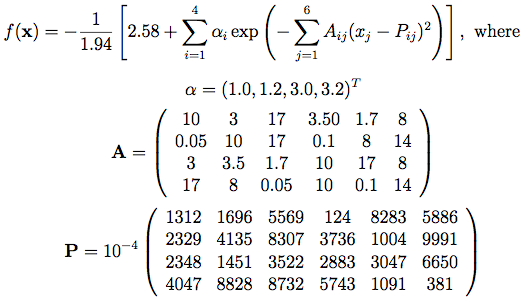

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
from functools import partial
import torch.nn as nn
from botorch.models import MultiTaskGP
import scipy.stats
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition import LogExpectedImprovement


In [2]:
import math
from botorch.test_functions import Branin


In [3]:
import os
import time

from copy import deepcopy
from typing import Optional

import numpy as np

import torch
from botorch.sampling import SobolQMCNormalSampler
from ax.core.data import Data
from ax.core.experiment import Experiment
from ax.core.generator_run import GeneratorRun
from ax.core.multi_type_experiment import MultiTypeExperiment
from ax.core.objective import Objective
from ax.core.observation import ObservationFeatures, observations_from_data
from ax.core.optimization_config import OptimizationConfig
from ax.core.parameter import ParameterType, RangeParameter
from ax.core.search_space import SearchSpace
from ax.metrics.hartmann6 import Hartmann6Metric
from ax.modelbridge.factory import get_sobol
from ax.modelbridge.registry import Models, MT_MTGP_trans, ST_MTGP_trans
from ax.modelbridge.torch import TorchModelBridge
from ax.modelbridge.transforms.convert_metric_names import tconfig_from_mt_experiment
from ax.plot.diagnostic import interact_batch_comparison
from ax.runners.synthetic import SyntheticRunner
from ax.utils.common.typeutils import checked_cast
from ax.utils.notebook.plotting import init_notebook_plotting, render

In [4]:
from botorch.test_functions import Hartmann
import numpy as np 
import torch 
import random 
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
# from botorch.fit import fit_gpytorch_model 
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
import time

In [5]:
# SEED = 8 
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# dtype = torch.double

In [6]:
# # 代码块1-生成初始训练集
# # 定义类对象
neg_hartmann6 = Hartmann(dim=6, negate=True)
neg_hartmann6.optimal_value #3.32237
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [7]:
obj = neg_hartmann6

In [8]:
class NoisyHartmann6(Hartmann):
    def __init__(self, dim=6, negate=True, noise_std=0.1):
        super().__init__(dim=dim, negate=negate)
        self.noise_std = noise_std

    def evaluate_true(self, X):
        # 计算原始的 Hartmann 函数值
        original_value = super().evaluate_true(X)
        # 添加噪声
        noise = torch.randn_like(original_value) * self.noise_std
        return original_value + noise

# 创建带噪声的 Hartmann6 函数实例
noisy_hartmann6 = NoisyHartmann6(noise_std=0.000000001)

In [9]:
# neg_hartmann6 = Hartmann(dim=6, negate=True)

# # 设定随机种子以确保结果可复现（可选）
# torch.manual_seed(42)

# # 生成一千个随机样本
# num_samples = 1000
# random_inputs = torch.rand(num_samples, 6)  # 生成 1000 个 6 维的随机输入点

# # 计算这些点的 neg_hartmann6 函数值
# values = neg_hartmann6(random_inputs)

# # 转换为 NumPy 数组以方便处理（可选）
# values_np = values.numpy()

# # 输出前 5 个值作为示例
# print("Sample values from neg_hartmann6:")
# print(random_inputs)

In [10]:
# 自定义函数：加0.1并对结果取余
def custom_function(x):
    # 确保输入是 PyTorch 张量
    x = torch.tensor(x, dtype=torch.float)
    
    # 对每个元素加 0.1
    x_modified = (x + 0.01)%1

    # 计算 neg_hartmann6 的结果
    value = neg_hartmann6(x_modified)
    
    # 对结果取余
    # 这里我们以某个常数进行取余，例如 1

    
    return value

# 示例输入（6维向量）
x = [0.95, 0.95, 0.95, 0.95, 0.95, 0.95]

# 计算自定义函数的结果
result = custom_function(x)

# 输出结果
print(f"The result of custom_function at {x} is {result.item()}")

The result of custom_function at [0.95, 0.95, 0.95, 0.95, 0.95, 0.95] is 0.00011397265188861638


In [11]:

# 初始化 Branin 函数
branin = Branin()

# # 在点 (x1, x2) 处评估函数
# x = torch.tensor([[-3.14159, 12.275]], dtype=torch.float)
# function_value = branin(x)

# print(f"Branin 函数在 {x} 处的值为 {function_value}")

In [12]:
class NegativeBranin(Branin):
    def forward(self, X: torch.Tensor, noise: bool = True) -> torch.Tensor:
        # 计算 Branin 函数的值并取负
        return -super().forward(X, noise=noise)

# 创建负值 Branin 函数实例
negative_branin = NegativeBranin()



In [13]:
class NegativeBraninShifted(Branin):
    def __init__(self, shift=0.01, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.shift = shift

    def forward(self, X: torch.Tensor, noise: bool = True) -> torch.Tensor:
        # 将 X 的 x_1 分量向左平移
        X_shifted = X.clone()
        X_shifted[:, 0] -= self.shift
        # 使用平移后的 X 计算 Branin 函数值并取负
        return -super().forward(X_shifted, noise=noise)

# 创建负值且平移后的 Branin 函数实例
branin1 = NegativeBraninShifted(shift=0.01)



In [14]:
def offline_hartmann6(x):
    # 确保 x 是一个 numpy 数组
    x = x.cpu().numpy() if torch.is_tensor(x) else np.array(x)

    # 确保 x 是一个二维数组
    if x.ndim == 1:
        x = x.reshape(1, -1)

    # 将 x 转换为 PyTorch 张量
    x = torch.tensor(x, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

    # 创建 Hartmann 函数实例
    hartmann6 = Hartmann(dim=6)

    # 对每个样本计算偏差调整后的结果
    results = []
    for sample in x:
        raw_res = hartmann6(sample.unsqueeze(0))  # 确保输入是二维张量
        m = -0.35
        if raw_res < m:
            adjusted_res = (1.5 * (raw_res - m)) + m
        else:
            adjusted_res = (6.0 * (raw_res - m)) + m
        
        # 取负值
        adjusted_res = -adjusted_res
        results.append(adjusted_res.item())  # 转换为 Python 标量并添加到结果中

    # 将结果转换为张量
    return torch.tensor(results, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# # 设定随机种子以确保结果可复现（可选）
# torch.manual_seed(42)

# # 生成一千个随机样本
# num_samples = 1000
# random_inputs = torch.rand(num_samples, 6)

# # 计算 neg_hartmann6 和 custom_function 的值
# neg_hartmann6_values = neg_hartmann6(random_inputs).numpy()
# noisy_hartmann6_values = np.array([noisy_hartmann6(x).item() for x in random_inputs])

# # 计算并输出两个函数输出的相关性
# correlation, _ = scipy.stats.pearsonr(neg_hartmann6_values.flatten(), noisy_hartmann6_values.flatten())
# print(f"Pearson correlation coefficient between neg_hartmann6 and offline_hartmann6 outputs: {correlation}")

In [16]:

def generate_initial_samples(num_samples, dim, lower_bound, upper_bound):

    # 选择计算设备
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    dtype = torch.double

    # 创建 Sobol 序列生成器
    sobol_engine = torch.quasirandom.SobolEngine(dim, scramble=True, seed=None)
    
    # 生成 Sobol 样本点
    train_x = sobol_engine.draw(num_samples).to(device, dtype=dtype)

    # 将 Sobol 点映射到指定范围内
    train_x = lower_bound + (upper_bound - lower_bound) * train_x

    return train_x

In [17]:
def generate_initial_samples1(num_samples, dim, lower_bound, upper_bound):

    # 选择计算设备
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    dtype = torch.double
    
    # 生成随机样本点
    train_x = (upper_bound - lower_bound) * torch.rand(num_samples, dim, device=device, dtype=dtype) + lower_bound
    
    return train_x

In [18]:
# train_x = generate_initial_samples(5,6,0,1)
# print(train_x)

# train_obj = neg_hartmann6(train_x).unsqueeze(-1)


# print(train_obj)


In [19]:
# def bayesian_optimization_experiment(num_experiments, n, device='cuda'):
#     all_experiments_results = []

#     for experiment in range(num_experiments):
#         train_x = generate_initial_samples(experiment, num_samples=5, dim=6, lower_bound=0, upper_bound=1).to(device)
#         train_obj = obj(train_x).unsqueeze(-1).to(device)

#         print(train_x)
#         bayes_best_values = []
#         for i in range(n):
#             t0 = time.monotonic()  # 开始计时
#             model = SingleTaskGP(
#                 train_X=train_x,
#                 train_Y=train_obj,
#                 input_transform=Normalize(d=6),
#                 outcome_transform=Standardize(m=1),
#             ).to(device)
#             mll = ExactMarginalLogLikelihood(model.likelihood, model)
#             fit_gpytorch_mll(mll)
#             best_value = train_obj.max()

#             bayes_best_values.append(best_value.cpu().item())

#             EI = ExpectedImprovement(model=model, best_f=best_value)
#             new_point_analytic, _ = optimize_acqf(
#                 acq_function=EI,  # acquisition function to guide the search
#                 bounds=torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=torch.float64),  # 6d unit hypercube
#                 q=1,  # generate one candidate location in each iteration
#                 num_restarts=20,  # number of starting points for multistart optimization
#                 raw_samples=100,  # number of samples for initialization
#                 options={},  # additional options if any
#             )

#             print(f"Nr. of optimization run: {i}")
#             train_x = torch.cat((train_x, new_point_analytic), 0)
#             train_obj_analytic = neg_hartmann6(new_point_analytic).unsqueeze(-1)
#             train_obj = torch.cat((train_obj, train_obj_analytic),)
#             print(f"New candidates are: {new_point_analytic}")
#             t1 = time.monotonic()  # 结束计时
#             print(f"Iteration {i} took {t1 - t0:.2f} seconds")
            
#         print(f"最优点: {bayes_best_values}")
#         all_experiments_results.append(bayes_best_values)

#     print("Bayes Best Values Over All Experiments:")
#     print(all_experiments_results)
#     all_experiments_results_cpu = [[val for val in experiment] for experiment in all_experiments_results]
#     # 转换 all_experiments_results 为 NumPy 数组
#     results_array = np.array(all_experiments_results_cpu)

#     print("Bayes Best Values Over All Experiments (Array):")
#     print(results_array)
#     return results_array

In [20]:
def fit_gp_model_and_select_next_point(train_x, train_obj, device):
    # 创建和拟合高斯过程模型
    model = SingleTaskGP(
        train_X=train_x,
        train_Y=train_obj,
        input_transform=Normalize(d=6),
        outcome_transform=Standardize(m=1),
    ).to(device)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # 找到当前最优值
    best_value = train_obj.max()

    # 使用 LogExpectedImprovement 选择下一个采样点
    LogEI = LogExpectedImprovement(model=model, best_f=best_value)
    new_point_analytic, _ = optimize_acqf(
        acq_function=LogEI,
        bounds=torch.tensor([[0.0] * 6, [1.0] * 6], device=device, dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    
    return new_point_analytic.squeeze(0)


In [24]:
def fit_gp_model_and_select_next_point2(train_x, train_obj, device):
        # 生成样本点
    initial_samples_np = generate_initial_samples(num_samples=1, dim=6, lower_bound=0, upper_bound=1)
    
    # 转换为张量
    initial_samples_tensor = torch.tensor(initial_samples_np, dtype=torch.float64)
    return initial_samples_tensor.squeeze(0)

In [25]:
def generate_initial_samples_with_custom_function1(num_samples_task1, num_samples_task2, input_dim, lower_bound, upper_bound, seed=None, device='cuda'):
    if seed is not None:
        torch.manual_seed(seed)
    
    # Ensure lower_bound and upper_bound are on the correct device
    lower_bound = lower_bound.to(device)
    upper_bound = upper_bound.to(device)
    
    # Generate initial samples for task 1
    samples_task1 = generate_initial_samples(num_samples_task1, input_dim, lower_bound, upper_bound).to(device)
    # Generate initial samples for task 2
    samples_task2 = generate_initial_samples(num_samples_task2, input_dim, lower_bound, upper_bound).to(device)
    
    return samples_task1, samples_task2

In [26]:
def generate_initial_samples_with_custom_function2(num_samples_task1, num_samples_task2, input_dim, lower_bound, upper_bound, seed=None, device='cuda'):
    if seed is not None:
        torch.manual_seed(seed)
    

    # Generate initial samples for task 1
    samples_task1 = generate_initial_samples(num_samples_task1, input_dim, lower_bound, upper_bound).to(device)
    # Generate initial samples for task 2
    samples_task2 = generate_initial_samples(num_samples_task2, input_dim, lower_bound, upper_bound).to(device)
    
    return samples_task1, samples_task2

In [47]:
def bayesian_optimization_experiment(num_experiments, n, fit_task_fn, obj_fn1, 
                                     obj_fn2=None, obj_fn3=None, initial_points_task1=None, 
                                     initial_points_task2=None, device='cuda', 
                                     task_type='single'):
    
    all_experiments_results = []

    for experiment in range(num_experiments):
        # 将列表中的张量转换到指定设备
        train_x_task1 = initial_points_task1[experiment].to(device)
        train_x_task2 = initial_points_task2[experiment].to(device) if initial_points_task2 is not None else None

        if task_type == 'multi' and obj_fn2 is not None:
            # 如果是多任务模型，并且提供了第二个目标函数
            train_obj1 = obj_fn1(train_x_task1).unsqueeze(-1).to(device)
            train_obj2 = obj_fn2(train_x_task2).unsqueeze(-1).to(device)
            
            # 将两个任务的数据和目标值分别拼接
            train_x = torch.cat((train_x_task1, train_x_task2), 0).to(device)
            train_obj = torch.cat((train_obj1, train_obj2), 0).to(device)
        else:
            # 单任务模型，只使用一个目标函数
            train_x = train_x_task1
            train_obj = obj_fn1(train_x).unsqueeze(-1).to(device)

        print(train_x)
        
        # 保存读取初始点时的最大值
        bayes_best_values = []
        current_max = obj_fn3(train_x[0].unsqueeze(0)).cpu().item()  # 初始化为第一个点的 obj_fn3 的目标值
        
        for i in range(min(5, train_x.size(0))):  # 确保索引不超出范围
            current_value = obj_fn3(train_x[i].unsqueeze(0)).cpu().item()
            current_max = max(current_max, current_value)
            bayes_best_values.append(current_max)

        for i in range(n):
            t0 = time.monotonic()

            # 运行指定的任务模型
            if task_type == 'multi':
                # 多任务模型需要传递任务参数
                task_tensor = torch.tensor([i % 2], device=device)  # 使用i % 2表示任务编号
                new_point_analytic = fit_task_fn(train_x, train_obj, device, task=task_tensor)
            else:
                # 单任务模型不需要任务参数
                new_point_analytic = fit_task_fn(train_x, train_obj, device)

            # 确保 new_point_analytic 是二维张量
            if new_point_analytic.dim() == 3:
                new_point_analytic = new_point_analytic.squeeze(0)
            if new_point_analytic.dim() == 1:
                new_point_analytic = new_point_analytic.unsqueeze(0)
            
            # 确保 new_point_analytic 的维度与 train_x 一致
            if new_point_analytic.size(1) != train_x.size(1):
                new_point_analytic = new_point_analytic.view(-1, train_x.size(1))  # 调整维度
            
            # 确保 new_point_analytic 在正确的设备上
            new_point_analytic = new_point_analytic.to(device)

            # 更新训练数据和目标值
            train_x = torch.cat((train_x, new_point_analytic), 0)
            train_obj_analytic = obj_fn1(new_point_analytic).unsqueeze(-1).to(device)
            train_obj = torch.cat((train_obj, train_obj_analytic), 0)

            # 更新当前最大值并加入到结果中
            obj_fn3_values = obj_fn3(new_point_analytic).cpu()  # 获取 obj_fn3 的输出张量
            max_obj_fn3_value = obj_fn3_values.max().item()     # 获取张量的最大值
            current_max = max(current_max, max_obj_fn3_value)   # 比较当前最大值
            bayes_best_values.append(current_max)

            print(f"Nr. of optimization run: {i}")
            print(f"New candidates are: {new_point_analytic}")
            t1 = time.monotonic()
            print(f"Iteration {i} took {t1 - t0:.2f} seconds")
            
        print(f"最优点: {bayes_best_values}")
        all_experiments_results.append(bayes_best_values)

    print("Bayes Best Values Over All Experiments:")
    print(all_experiments_results)
    all_experiments_results_cpu = [[val for val in experiment] for experiment in all_experiments_results]
    results_array = np.array(all_experiments_results_cpu)

    print("Bayes Best Values Over All Experiments (Array):")
    print(results_array)
    return results_array


In [28]:
# results2 = bayesian_optimization_experiment(
#     num_experiments=10,
#     n=25,
#     obj_fn1=negative_branin,
#     obj_fn2=branin1,
#     obj_fn3=negative_branin,
#     initial_points_task1=initial_points_task11,  # 传递生成的初始样本
#     initial_points_task2=initial_points_task22,  # 传递生成的初始样本
#     fit_task_fn=fit_gp_model_and_select_next_point2,
#     device='cuda',
#     task_type='single'  # 表示运行单任务模型
# )

In [29]:


# initial_points_task11 = [generate_initial_samples_with_custom_function2(5,5, 6, 0, 1, seed=i)[0] for i in range(10)]
# initial_points_task22 = None  # 如果你没有任务2的初始点，可以设置为 None
# initial_points_task23 = [generate_initial_samples_with_custom_function2(20,20, 6, 0, 1, seed=i)[0] for i in range(20)]

In [30]:
# lower_bounds = [-5, 0.0]  # Lower bounds for each dimension
# upper_bounds = [10.0, 15.0]  # Upper bounds for each dimension


In [31]:
# initial_points_task11 = [
#     generate_initial_samples_with_custom_function1(
#         2, 2, 2, torch.tensor(lower_bounds), torch.tensor(upper_bounds), seed=i
#     )[0] for i in range(10)
# ]

# initial_points_task22 = None  # If you do not have initial points for task 2, you can set it to None

# initial_points_task23 = [
#     generate_initial_samples_with_custom_function1(
#         10, 10, 2, torch.tensor(lower_bounds), torch.tensor(upper_bounds), seed=i
#     )[0] for i in range(20)
# ]

In [32]:


# results = bayesian_optimization_experiment(
#     num_experiments=10,
#     n=25,
#     obj_fn1=obj,
#     obj_fn2=offline_hartmann6,
#     obj_fn3=obj,
#     initial_points_task1=initial_points_task11,  # 传递生成的初始样本
#     initial_points_task2=initial_points_task23,  # 传递生成的初始样本
#     fit_task_fn=fit_multi_task_gp_model_and_select_next_point,
#     device='cuda',
#     task_type='multi'
# )

In [33]:

# results1 = bayesian_optimization_experiment(
#     num_experiments=10,
#     n=25,
#     obj_fn1=obj,
#     obj_fn2=None, 
#     initial_points_task1=initial_points_task11,  # 传递生成的初始样本
#     initial_points_task2=initial_points_task22,  # 传递生成的初始样本
#     fit_task_fn=fit_gp_model_and_select_next_point,
#     device='cuda',
#     task_type='single'  # 表示运行单任务模型
# )

In [34]:

# results2 = bayesian_optimization_experiment(
#     num_experiments=10,
#     n=25,
#     obj_fn1=obj,
#     obj_fn2=None, 
#     initial_points_task1=initial_points_task11,  # 传递生成的初始样本
#     initial_points_task2=initial_points_task22,  # 传递生成的初始样本
#     fit_task_fn=fit_gp_model_and_select_next_point2,
#     device='cuda',
#     task_type='single'  # 表示运行单任务模型
# )

In [35]:
from pyDOE2 import lhs
from scipy.stats import qmc

In [36]:
# 生成 LHS 样本
def generate_lhs_samples(num_features, num_samples):
    lhs_sampler = qmc.LatinHypercube(d=num_features)
    samples = lhs_sampler.random(n=num_samples)
    return samples

# 管理 LHS 样本并按顺序检索它们的类
class SampleProvider:
    def __init__(self, num_features, num_samples):
        self.samples_np = generate_lhs_samples(num_features, num_samples)
        self.samples_tensor = torch.tensor(self.samples_np, dtype=torch.float64)
        self.current_index = 0

    def get_next_sample(self):
        if self.current_index < self.samples_tensor.size(0):
            sample = self.samples_tensor[self.current_index]
            self.current_index += 1
            return sample
        else:
            raise IndexError("没有更多样本可用了。")


In [37]:
def generate_initial_samples_with_custom_function(num_samples_task1, num_samples_task2, input_dim, lower_bound, upper_bound, seed=None, device='cuda'):
    if seed is not None:
        np.random.seed(seed)
    
    # Convert lower_bound and upper_bound to tensors and move them to the correct device
    lower_bound = torch.tensor(lower_bound, dtype=torch.float32).to(device)
    upper_bound = torch.tensor(upper_bound, dtype=torch.float32).to(device)
    
    # Use LHS to generate samples
    samples_task1 = generate_lhs_samples(input_dim, num_samples_task1)
    samples_task2 = generate_lhs_samples(input_dim, num_samples_task2)
    
    # Convert samples to tensors and scale to the specified range
    samples_task1 = torch.tensor(samples_task1, dtype=torch.float32).to(device)
    samples_task1 = samples_task1 * (upper_bound - lower_bound) + lower_bound

    samples_task2 = torch.tensor(samples_task2, dtype=torch.float32).to(device)
    samples_task2 = samples_task2 * (upper_bound - lower_bound) + lower_bound
    
    return samples_task1, samples_task2

In [38]:
# initial_points_task1 = [generate_initial_samples_with_custom_function(5, 20, 6, 0, 1, seed=i)[0] for i in range(10)]
# initial_points_task2 = None  # 如果你没有任务2的初始点，可以设置为 None

In [39]:
# initial_points_task1 = [
#     generate_initial_samples_with_custom_function(
#         5, 20, 2, lower_bounds, upper_bounds, seed=i
#     )[0] for i in range(10)
# ]
# initial_points_task2 = None  # 如果你没有任务2的初始点，可以设置为 None

In [40]:
# def bayesian_optimization_experiment(num_experiments, n, generate_initial_samples_fn, fit_gp_model_and_select_next_point_fn, obj_fn, device='cuda'):
#     all_experiments_results = []

#     for experiment in range(num_experiments):
#         # 使用传入的函数生成初始样本
#         train_x = generate_initial_samples_fn()
#         train_obj = obj_fn(train_x).unsqueeze(-1).to(device)

#         print(train_x)
#         bayes_best_values = []
#         for i in range(n):
#             t0 = time.monotonic()  # 开始计时

#             # 使用传入的函数创建和拟合高斯过程模型并选择下一个采样点
#             new_point_analytic = fit_gp_model_and_select_next_point_fn(train_x, train_obj, device)

           
            
#             best_value = train_obj.max()

#             bayes_best_values.append(best_value.cpu().item())

#             print(f"Nr. of optimization run: {i}")
#             train_x = torch.cat((train_x, new_point_analytic.unsqueeze(0)), 0)  # 扩展 new_point_analytic 维度
#             train_obj_analytic = obj_fn(new_point_analytic.unsqueeze(0)).unsqueeze(-1)  # 确保 train_obj_analytic 是二维的

            

#             train_obj = torch.cat((train_obj, train_obj_analytic), 0)  # 拼接 train_obj 和 train_obj_analytic
#             print(f"New candidates are: {new_point_analytic}")
#             t1 = time.monotonic()  # 结束计时
#             print(f"Iteration {i} took {t1 - t0:.2f} seconds")
            
#         print(f"最优点: {bayes_best_values}")
#         all_experiments_results.append(bayes_best_values)

#     print("Bayes Best Values Over All Experiments:")
#     print(all_experiments_results)
#     all_experiments_results_cpu = [[val for val in experiment] for experiment in all_experiments_results]
#     # 转换 all_experiments_results 为 NumPy 数组
#     results_array = np.array(all_experiments_results_cpu)

#     print("Bayes Best Values Over All Experiments (Array):")
#     print(results_array)
#     return results_array


In [41]:
# 类似你提供的函数
def zj(train_x, train_obj, device):
    return sample_provider.get_next_sample()

In [42]:
# # 示例使用
# num_features = 6
# num_samples = 250
# sample_provider = SampleProvider(num_features, num_samples)



# # 检索一个样本（每次调用函数时都会这样做）
# next_sample = fit_gp_model_and_select_next_point2(None, None, None)
# print(next_sample)

In [43]:


# results3 = bayesian_optimization_experiment(
#     num_experiments=10,
#     n=25,
#     fit_task_fn=zj,  # 你的模型拟合函数
#     obj_fn1=obj,     # 目标函数1
#     obj_fn2=None,    # 如果没有第二个目标函数，设置为 None
#     initial_points_task1=initial_points_task1,  # 传递生成的初始样本
#     initial_points_task2=initial_points_task2,  # 传递生成的初始样本
#     device='cuda',
#     task_type='single'  # 表示运行单任务模型
# )

In [44]:
# # 计算每一列的均值
# confidence_level = 0.95
# means_random = np.mean(results2, axis=0)

# # 计算每一列的标准误差
# standard_errors2 = stats.sem(results2, axis=0)
# z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# # 计算置信区间
# ci_random = z_value * standard_errors2






# #贝叶斯优化
# means_bayes = np.mean(results, axis=0)

# # 计算每一列的标准误差
# standard_errors = stats.sem(results, axis=0)

# # 计算置信区间
# ci_bayes = z_value * standard_errors



# #贝叶斯优化1
# means_bayes1 = np.mean(results1, axis=0)

# # 计算每一列的标准误差
# standard_errors1 = stats.sem(results1, axis=0)
# ci_bayes1 = z_value * standard_errors1


# # 计算置信区间
# ci_bayes = z_value * standard_errors
# ###正交
# means_orthogonal = np.mean(results3, axis=0)
# standard_errors3 = stats.sem(results3, axis=0)


# # 计算置信区间
# ci_orthogonal = z_value * standard_errors3

In [45]:
# def plot_optimal_values_with_confidence_intervals(means_random, ci_random, means_bayes, ci_bayes, means_orthogonal, ci_orthogonal):
#     # x轴的索引
#     x = np.arange(len(means_bayes))

#     # 创建图形
#     plt.figure(figsize=(10, 6))

#     # 绘制带有误差条的均值图
#     plt.errorbar(x, means_random, yerr=ci_random, fmt='-o', label='random', color='blue', ecolor='blue', capsize=5)
#     plt.errorbar(x, means_bayes1, yerr=ci_bayes1, fmt='-o', label='STGP+logEI', color='y', ecolor='y', capsize=5)
#     plt.errorbar(x, means_orthogonal, yerr=ci_orthogonal, fmt='-o', label='orthogonal', color='black', ecolor='black', capsize=5)
#     plt.errorbar(x, means_bayes, yerr=ci_bayes, fmt='-o', label='MTGP+logEI', color='r', ecolor='r', capsize=5)

#     # 绘制表示Hartmann 6D函数最大值的横线
#     plt.axhline(y=3.32237, color='green', linestyle='--', label='Hartmann 6D max')
#     # plt.axhline(y=-0.397887, color='green', linestyle='--', label='negative_branin max')
#     # 图形标题和标签
#     plt.title('The optimal values and confidence intervals found by different methods')
#     plt.title('The optimal values and confidence intervals found by different methods')
#     plt.xlabel('Number of Iterations')
#     plt.ylabel('The optimal value at each iteration')
#     plt.legend()

#     # 显示图形
#     plt.show()

In [46]:
# plot_optimal_values_with_confidence_intervals(means_random, ci_random, means_bayes, ci_bayes, means_orthogonal, ci_orthogonal)